In [1]:
using Oceananigans
using JLD2
using CairoMakie
using Statistics
using ImageFiltering: imfilter, Kernel.gaussian
using ZipFile

[ Info: Oceananigans will use 4 threads


In [2]:
runname = "default"
@inline function make_∇b²_timeseries(runname)
    foldername = "../scratch/filament-instability/$runname"
    filename = "down_front_mean.jld2"
    frames, grid = jldopen("$foldername/$filename") do file
        keys(file["timeseries/t"]), file["serialized/grid"]
    end
    xᶜᵃᵃ = xnodes(Center, grid)
    σ=(8,)
    file = jldopen("$foldername/$filename")
    ts = [file["timeseries/t/$frame"] for frame in frames]
    ∇b² = map(frames[end-1000:end]) do frame
        b = imfilter(file["timeseries/b_dfm/$frame"][:, 1, end], gaussian(σ))
        mean(((circshift(b, -1) - circshift(b, 1)) ./ (circshift(xᶜᵃᵃ, -1) - circshift(xᶜᵃᵃ, 1))).^2)# / mean(b.^2)
    end
    close(file)
    return ∇b²
end

make_∇b²_timeseries (generic function with 1 method)

In [3]:
@inline function qᶜᶜᶜ(vᶜᶠᶜ, bᶜᶜᶜ, xᶜᵃᵃ, xᶠᵃᵃ, zᵃᵃᶜ, zᵃᵃᶠ)
    # Integrate
    Δzᵃᵃᶜ = reshape(diff(zᵃᵃᶠ), 1, length(zᵃᵃᶜ))
    Δx = xᶠᵃᵃ[2] - xᶠᵃᵃ[1]
    ∂xbᶜᶜᶜ = (circshift(bᶜᶜᶜ, (-1, 0)) - circshift(bᶜᶜᶜ, (1, 0))) ./ (2Δx)
    ∂xvᶜᶠᶜ = (circshift(vᶜᶠᶜ, (-1, 0)) - circshift(vᶜᶠᶜ, (1, 0))) ./ (2Δx)

    ∂zbᶜᶜᶜ = (bᶜᶜᶜ - circshift(bᶜᶜᶜ, (0, 1))) ./ Δzᵃᵃᶜ
    ∂zbᶜᶜᶜ[:, 1] .= ∂zbᶜᶜᶜ[:, 2]

    ∂zvᶜᶠᶜ = (vᶜᶠᶜ - circshift(vᶜᶠᶜ, (0, 1))) ./ Δzᵃᵃᶜ
    ∂zvᶜᶠᶜ[:, 1] .= ∂zvᶜᶠᶜ[:, 2]
    return (∂xvᶜᶠᶜ .+ 1) .* ∂zbᶜᶜᶜ .- ∂zvᶜᶠᶜ .* ∂xbᶜᶜᶜ
end
@inline function Tq(vᶜᶠᶜ, bᶜᶜᶜ, xᶜᵃᵃ, xᶠᵃᵃ, zᵃᵃᶜ, zᵃᵃᶠ)
    # Integrate
    Δzᵃᵃᶜ = reshape(diff(zᵃᵃᶠ), 1, length(zᵃᵃᶜ))
    Δx = xᶠᵃᵃ[2] - xᶠᵃᵃ[1]
    ∂xbᶜᶜᶜ = (circshift(bᶜᶜᶜ, (-1, 0)) - circshift(bᶜᶜᶜ, (1, 0))) ./ (2Δx)
    ∂xvᶜᶠᶜ = (circshift(vᶜᶠᶜ, (-1, 0)) - circshift(vᶜᶠᶜ, (1, 0))) ./ (2Δx)

    ∂zbᶜᶜᶜ = (bᶜᶜᶜ - circshift(bᶜᶜᶜ, (0, 1))) ./ Δzᵃᵃᶜ
    ∂zbᶜᶜᶜ[:, 1] .= ∂zbᶜᶜᶜ[:, 2]

    ∂zvᶜᶠᶜ = (vᶜᶠᶜ - circshift(vᶜᶠᶜ, (0, 1))) ./ Δzᵃᵃᶜ
    ∂zvᶜᶠᶜ[:, 1] .= ∂zvᶜᶠᶜ[:, 2]
    
    return sum(((∂xvᶜᶠᶜ .+ 1) .* ∂zbᶜᶜᶜ .- ∂zvᶜᶠᶜ .* ∂xbᶜᶜᶜ) .* (Δx .* Δzᵃᵃᶜ))
end

@inline function make_Vq_timeseries(runname)
    foldername = "../scratch/filament-instability/$runname"
    filename = "down_front_mean.jld2"
    paramfilename = "parameters.jld2"
    frames, grid = jldopen("$foldername/$filename") do file
        keys(file["timeseries/t"]), file["serialized/grid"]
    end
    sp = jldopen("$foldername/$paramfilename") do file
        file["parameters/simulation"]
    end
    xᶜᵃᵃ = xnodes(Center, grid)
    zᵃᵃᶜ = znodes(Center, grid)
    xᶠᵃᵃ = xnodes(Face, grid)
    zᵃᵃᶠ = znodes(Face, grid)
    σ=(8, 0)
    file = jldopen("$foldername/$filename")
    ts = [file["timeseries/t/$frame"] for frame in frames]
    q = map(frames[end-1000:end]) do frame
        (v, b) = map(x->imfilter(file["timeseries/$x/$frame"][:, 1, :], gaussian(σ, 4 .* σ .+ 1), "circular"), ("v_dfm", "b_dfm"))
        Tq(v, b, xᶜᵃᵃ, xᶠᵃᵃ, zᵃᵃᶜ, zᵃᵃᶠ)
    end
    close(file)
    return q
end
@inline function make_Δq_timeseries(runname)
    foldername = "../scratch/filament-instability/$runname"
    filename = "down_front_mean.jld2"
    paramfilename = "parameters.jld2"
    frames, grid = jldopen("$foldername/$filename") do file
        keys(file["timeseries/t"]), file["serialized/grid"]
    end
    sp = jldopen("$foldername/$paramfilename") do file
        file["parameters/simulation"]
    end
    xᶠᵃᵃ = xnodes(Face, grid)
    σ=(8, 0)
    file = jldopen("$foldername/$filename")
    ts = [file["timeseries/t/$frame"] for frame in frames]
    q = map(frames[end-1000:end]) do frame
        sp.B₀ * grid.Lx / 100
    end
    close(file)
    return cumsum(q)
end

make_Δq_timeseries (generic function with 1 method)

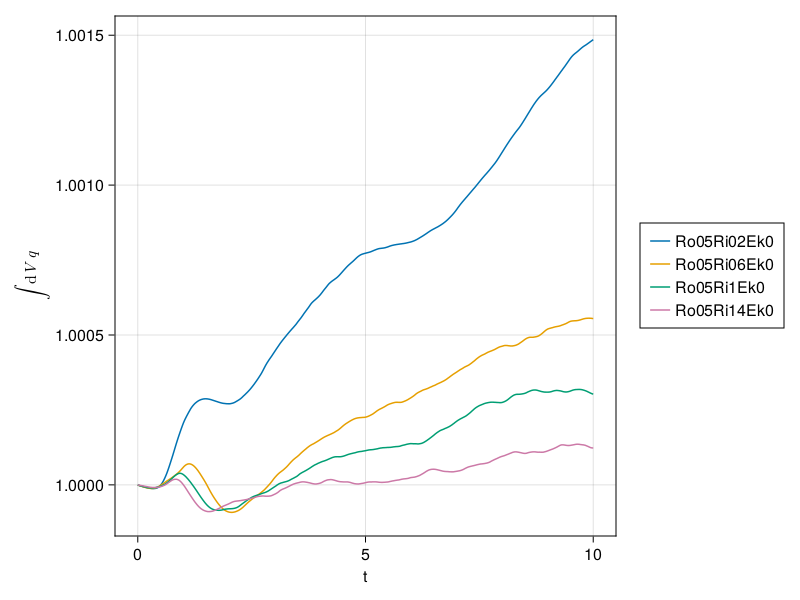

In [4]:
Ros = ["05"]
Ris = ["02", "06", "1", "14"]
Eks = ["0"]
runnames = ["Ro$(Ro)Ri$(Ri)Ek$(Ek)" for Ro in Ros, Ri in Ris, Ek in Eks]
Vqs = map(make_Vq_timeseries, runnames);
fig = Figure()
ax = Axis(fig[1, 1]; xlabel="t", ylabel=L"\int \text {d} V \;q")
lns = [lines!(ax, range(0, 10, 1000), Vq[2:end]/Vq[1]) for Vq in Vqs[1, :, 1]]
Legend(fig[1, 2], lns, runnames[1, :, 1])
fig

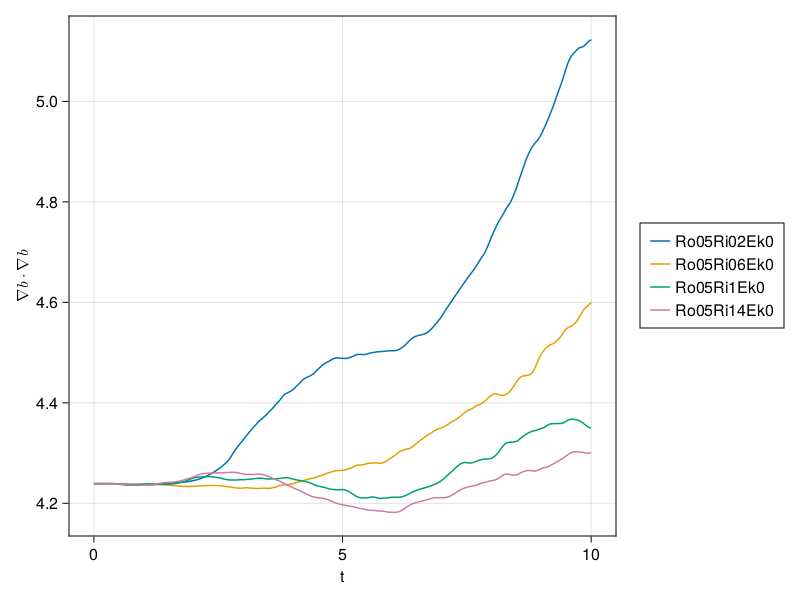

In [5]:
Ros = ["05"]
Ris = ["02", "06", "1", "14"]
Eks = ["0"]
runnames = ["Ro$(Ro)Ri$(Ri)Ek$(Ek)" for Ro in Ros, Ri in Ris, Ek in Eks]
∇b²s = map(make_∇b²_timeseries, runnames);
fig = Figure()
ax = Axis(fig[1, 1]; xlabel="t", ylabel=L"\nabla b \cdot \nabla b")
lns = [lines!(ax, range(0, 10, 1000), ∇b²[2:end]) for ∇b² in ∇b²s[1, :, 1]]
Legend(fig[1, 2], lns, runnames[1, :, 1])
fig

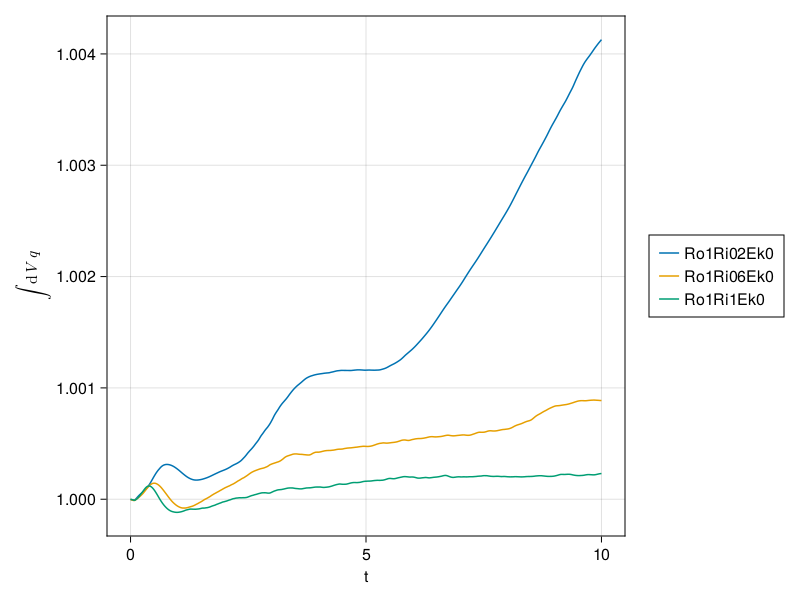

In [6]:
Ros = ["1"]
Ris = ["02", "06", "1"]
#Eks=["0"]
Eks = ["0"]
runnames = ["Ro$(Ro)Ri$(Ri)Ek$(Ek)" for Ro in Ros, Ri in Ris, Ek in Eks]
Vqs = map(make_Vq_timeseries, runnames);
fig = Figure()
ax = Axis(fig[1, 1]; xlabel="t", ylabel=L"\int \text {d} V \;q")
lns = [lines!(ax, range(0, 10, 1000), Vq[2:end] ./ Vq[1]) for Vq in Vqs[1, :, 1]]
Legend(fig[1, 2], lns, runnames[1, :, 1])
fig

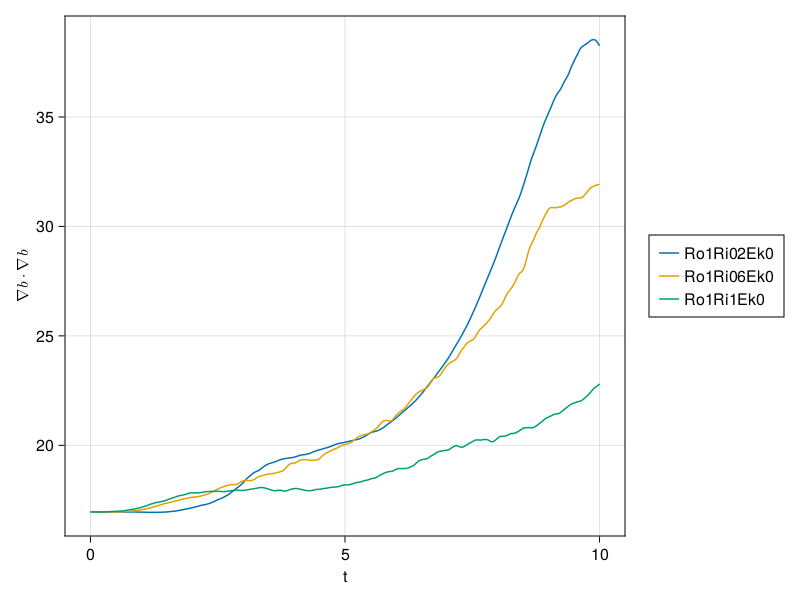

In [7]:
Ros = ["1"]
Ris = ["02", "06", "1"]
Eks = ["0"]
runnames = ["Ro$(Ro)Ri$(Ri)Ek$(Ek)" for Ro in Ros, Ri in Ris, Ek in Eks]
∇b²s = map(make_∇b²_timeseries, runnames);
fig = Figure()
ax = Axis(fig[1, 1]; xlabel="t", ylabel=L"\nabla b \cdot \nabla b")
lns = [lines!(ax, range(0, 10, 1000), ∇b²[2:end]) for ∇b² in ∇b²s[1, :, 1]]
Legend(fig[1, 2], lns, runnames[1, :, 1])
fig

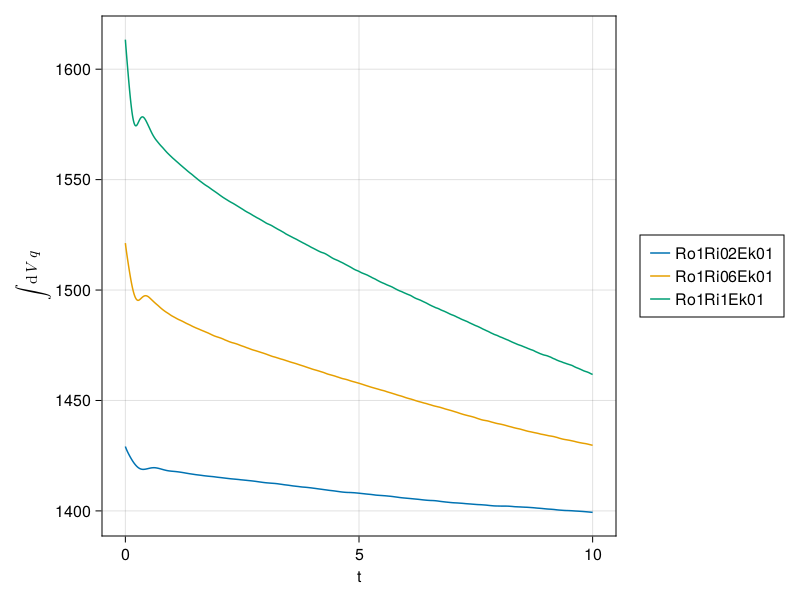

In [8]:
Ros = ["1"]
Ris = ["02", "06", "1"]
Eks = ["01"]
runnames = ["Ro$(Ro)Ri$(Ri)Ek$(Ek)" for Ro in Ros, Ri in Ris, Ek in Eks]
Vqs = map(make_Vq_timeseries, runnames);
fig = Figure()
ax = Axis(fig[1, 1]; xlabel="t", ylabel=L"\int \text {d} V \;q")
lns = [lines!(ax, range(0, 10, 1000), Vq[2:end]) for Vq in Vqs[1, :, 1]]
Legend(fig[1, 2], lns, runnames[1, :, 1])
fig

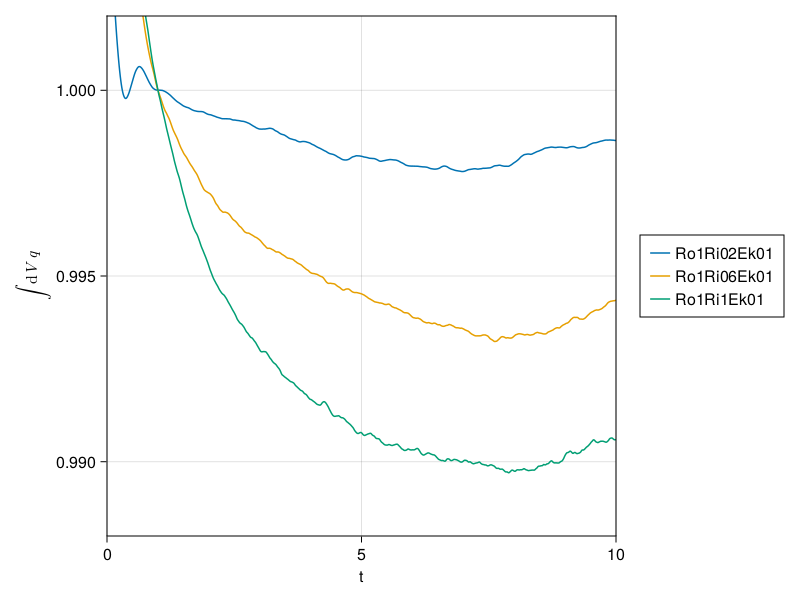

In [9]:
Ros = ["1"]
Ris = ["02", "06", "1"]
Eks = ["01"]
runnames = ["Ro$(Ro)Ri$(Ri)Ek$(Ek)" for Ro in Ros, Ri in Ris, Ek in Eks]
Δqs = map(make_Δq_timeseries, runnames);
fig = Figure()
ax = Axis(fig[1, 1]; xlabel="t", ylabel=L"\int \text {d} V \;q", limits=(0, 10, 0.988, 1.002))
lns = [lines!(ax, range(0, 10, 1000), (10*Δq[2:end] .+ Vq[2:end]) / (10*Δq[102] .+ Vq[102])) for (Δq, Vq) in zip(Δqs[1, :, 1], Vqs[1, :, 1])]
Legend(fig[1, 2], lns, runnames[1, :, 1])
fig

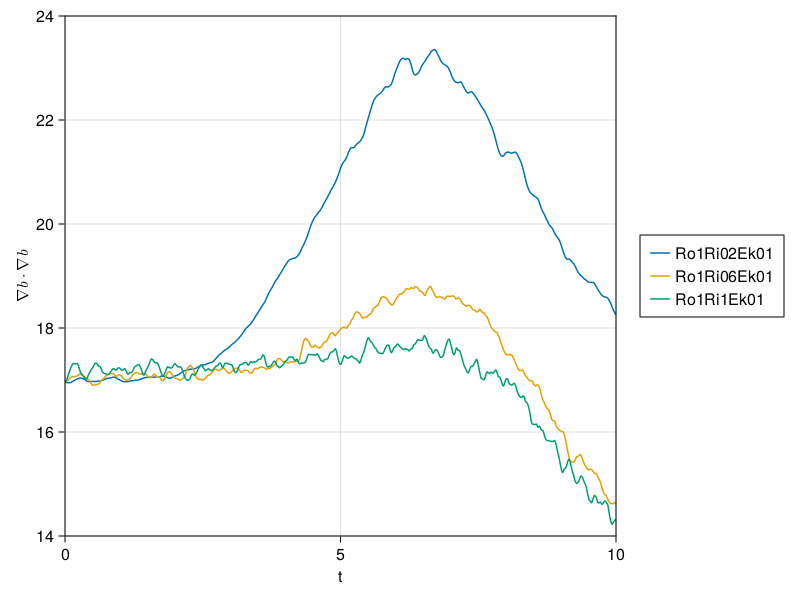

In [10]:
Ros = ["1"]
Ris = ["02", "06", "1"]
Eks = ["01"]
runnames = ["Ro$(Ro)Ri$(Ri)Ek$(Ek)" for Ro in Ros, Ri in Ris, Ek in Eks]
∇b²s = map(make_∇b²_timeseries, runnames);
fig = Figure()
ax = Axis(fig[1, 1]; xlabel="t", ylabel=L"\nabla b \cdot \nabla b", limits=(0, 10, 14, 24))
lns = [lines!(ax, range(0, 10, 1000), ∇b²[2:end]) for ∇b² in ∇b²s[1, :, 1]]
Legend(fig[1, 2], lns, runnames[1, :, 1])
fig

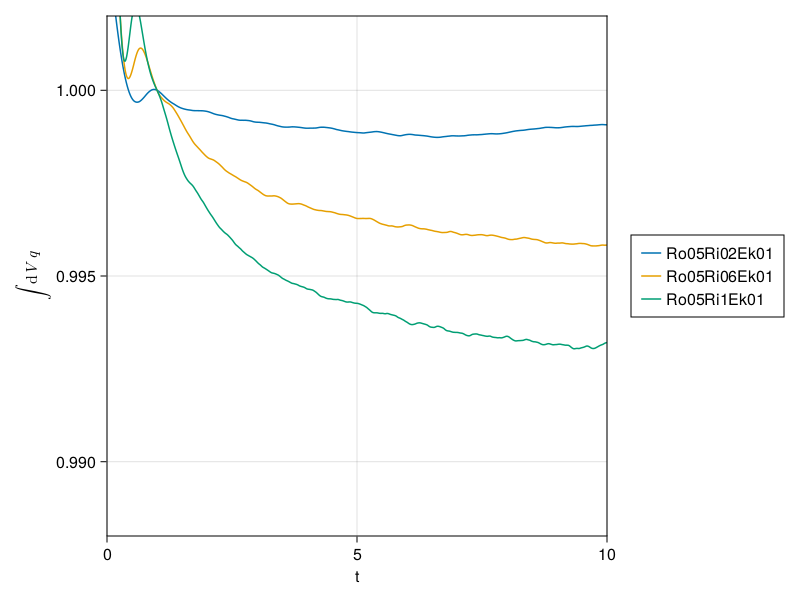

In [11]:
Ros = ["05"]
Ris = ["02", "06", "1"]
Eks = ["01"]
runnames = ["Ro$(Ro)Ri$(Ri)Ek$(Ek)" for Ro in Ros, Ri in Ris, Ek in Eks]
Vqs = map(make_Vq_timeseries, runnames);
fig = Figure()
ax = Axis(fig[1, 1]; xlabel="t", ylabel=L"\int \text {d} V \;q")
lns = [lines!(ax, range(0, 10, 1000), Vq[2:end]) for Vq in Vqs[1, :, 1]]
Legend(fig[1, 2], lns, runnames[1, :, 1])
fig
Δqs = map(make_Δq_timeseries, runnames);
fig = Figure()
ax = Axis(fig[1, 1]; xlabel="t", ylabel=L"\int \text {d} V \;q", limits=(0, 10, 0.988, 1.002))
lns = [lines!(ax, range(0, 10, 1000), (10*Δq[2:end] .+ Vq[2:end]) / (10*Δq[102] .+ Vq[102])) for (Δq, Vq) in zip(Δqs[1, :, 1], Vqs[1, :, 1])]
Legend(fig[1, 2], lns, runnames[1, :, 1])
fig

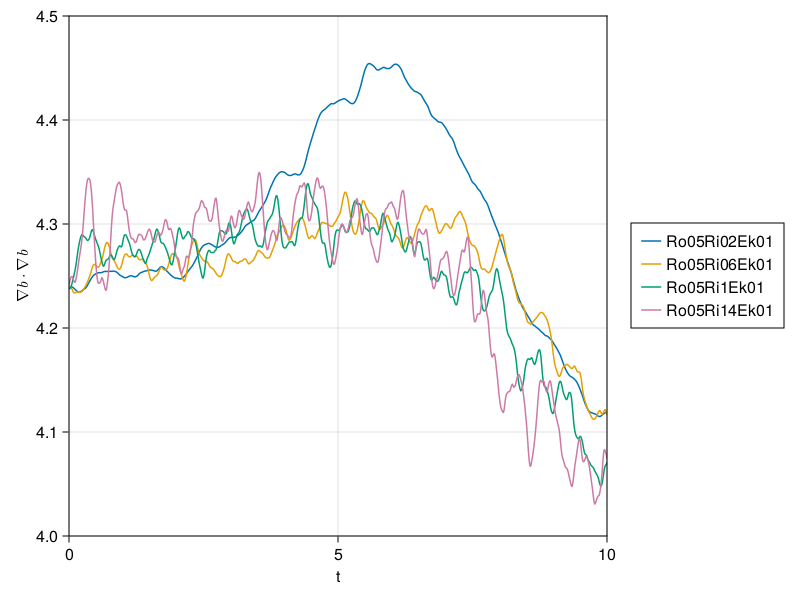

In [19]:
Ros = ["05"]
Ris = ["02", "06", "1", "14"]
Eks = ["01"]
runnames = ["Ro$(Ro)Ri$(Ri)Ek$(Ek)" for Ro in Ros, Ri in Ris, Ek in Eks]
∇b²s = map(make_∇b²_timeseries, runnames);
fig = Figure()
ax = Axis(fig[1, 1]; xlabel="t", ylabel=L"\nabla b \cdot \nabla b", limits=(0, 10, 4, 4.5))
lns = [lines!(ax, range(0, 10, 1000), ∇b²[2:end]) for ∇b² in ∇b²s[1, :, 1]]
Legend(fig[1, 2], lns, runnames[1, :, 1])
fig